# Instacart Market Basket Analysis

The goal of the competition is to predict which products will be in a user's next order. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users.

For each user, 4 and 100 of their orders are given, with the sequence of products purchased in each order.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import tensorflow as tf
# import gensim
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Load and prepare the data

In [2]:
data_path = 'data'

# Links orders to products
priors = pd.read_csv(data_path + '/order_products__prior.csv')
train = pd.read_csv(data_path + '/order_products__train.csv')

# Order metadata
orders = pd.read_csv(data_path + '/orders.csv').set_index('order_id')

# Aisles & departments used to classify products
products = pd.read_csv(data_path + '/products.csv').set_index('product_id')
aisles = pd.read_csv(data_path + '/aisles.csv').set_index('aisle_id')
departments = pd.read_csv(data_path + '/departments.csv').set_index('department_id')

In [3]:
print('priors {}: {}'.format(priors.shape, ', '.join(priors.columns)))
print('train {}: {}'.format(train.shape, ', '.join(train.columns)))

print('orders {}: {}'.format(orders.shape, ', '.join(orders.columns)))

print('products {}: {}'.format(products.shape, ', '.join(products.columns)))
print('aisles {}: {}'.format(aisles.shape, ', '.join(aisles.columns)))
print('departments {}: {}'.format(departments.shape, ', '.join(departments.columns)))

priors (32434489, 4): order_id, product_id, add_to_cart_order, reordered
train (1384617, 4): order_id, product_id, add_to_cart_order, reordered
orders (3421083, 6): user_id, eval_set, order_number, order_dow, order_hour_of_day, days_since_prior_order
products (49688, 3): product_name, aisle_id, department_id
aisles (134, 1): aisle
departments (21, 1): department


In [4]:
priors.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [5]:
train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [6]:
orders.head()

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,
2539329,1,prior,1,2,8,NaN
2398795,1,prior,2,3,7,15.0
473747,1,prior,3,3,12,21.0
2254736,1,prior,4,4,7,29.0
431534,1,prior,5,4,15,28.0


In [15]:
orders[orders['eval_set'] == 'train'].head()

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,
1187899,1,train,11,4,8,14.0
1492625,2,train,15,1,11,30.0
2196797,5,train,5,0,11,6.0
525192,7,train,21,2,11,6.0
880375,8,train,4,1,14,10.0


In [16]:
orders[orders['eval_set'] == 'test'].head()

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,
2774568,3,test,13,5,15,11.0
329954,4,test,6,3,12,30.0
1528013,6,test,4,3,16,22.0
1376945,11,test,8,6,11,8.0
1356845,12,test,6,1,20,30.0


As we could see, `orders.csv` has all the information about the given order id like the user who has purchased the order, when was it purchased, days since prior order and so on.

The columns present in `order_products_train.csv` and `order_products_prior.csv` are same. Then what is the difference between these files?

As mentioned earlier, in this dataset, 4 to 100 orders of a customer are given (we will look at this later) and we need to predict the **products** that will be re-ordered. So the last order of the user has been taken out and divided into train and test sets. All the prior order informations of the customer are present in order_products_prior file. We can also note that there is a column in `orders.csv` file called `eval_set` which tells us as to which of the three datasets (prior, train or test) the given row goes to.

`order_products__*.csv` files have more detailed information about the products that been bought in the given order along with the re-ordered status.

In [7]:
products.head()

,product_name,aisle_id,department_id
product_id,,,
1,Chocolate Sandwich Cookies,61,19
2,All-Seasons Salt,104,13
3,Robust Golden Unsweetened Oolong Tea,94,7
4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
5,Green Chile Anytime Sauce,5,13


In [8]:
aisles.head()

,aisle
aisle_id,
1,prepared soups salads
2,specialty cheeses
3,energy granola bars
4,instant foods
5,marinades meat preparation


In [9]:
departments.head()

,department
department_id,
1,frozen
2,other
3,bakery
4,produce
5,alcohol


We see that these files just provide classification labels to each product.

We don't actually need the names of these labels, so let's just merge these product, aisle, and department ids with the priors.

In [10]:
# priors_orders = priors.join(orders, on='order_id', how='left')
# priors_orders.head()
products.drop('product_name', inplace=True, axis=1)
priors = pd.merge(priors, products, left_on='product_id', right_index=True, how='left')
priors.head()

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id
0,2,33120,1,1,86,16
1,2,28985,2,1,83,4
2,2,9327,3,0,104,13
3,2,45918,4,1,19,13
4,2,30035,5,0,17,13


## Exploring the data

Since our objective is to figure out the re-orders, let us check out the re-order percentage in prior set and train set.

In [11]:
# percentage of reorders in prior set
print('priors: {}'.format(priors.reordered.sum() * 1. / priors.shape[0]))
# percentage of reorders in training set
print('train: {}'.format(train.reordered.sum() * 1. / train.shape[0]))

priors: 0.589697466792
train: 0.598594412751


Looks like about 59% of the products in an order are reordered products.

Now, lets explore it across time.

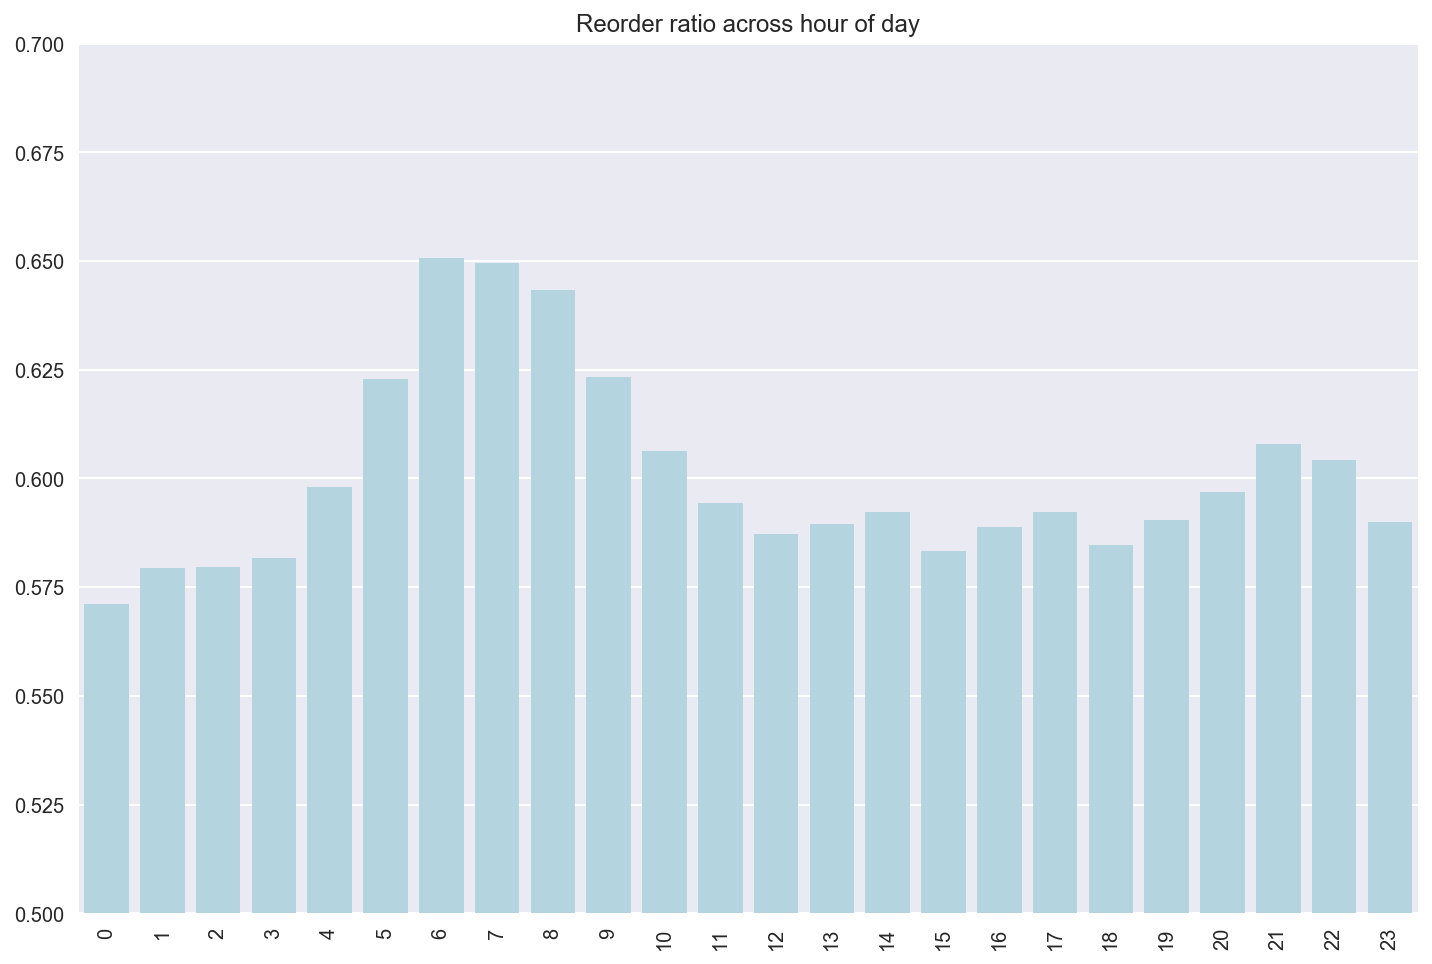

In [12]:
trainXorders = pd.merge(train, orders, left_on='order_id', right_index=True, how='left')

trainXorders_hours = trainXorders.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
plt.figure(figsize=(12,8))
sns.barplot(trainXorders_hours['order_hour_of_day'].values, trainXorders_hours['reordered'].values, color='lightblue')
plt.title("Reorder ratio across hour of day")
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

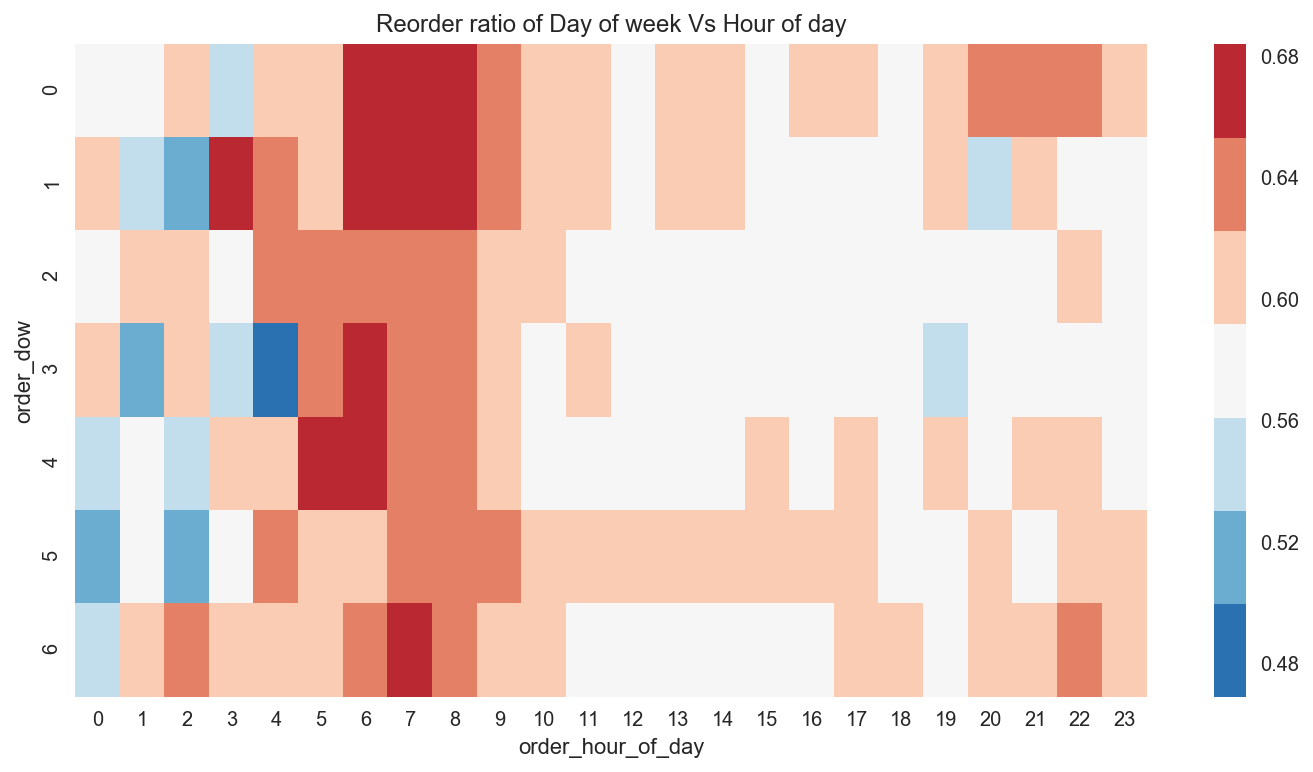

In [13]:
trainXorders_dow = trainXorders.groupby(['order_dow', 'order_hour_of_day'])['reordered'].aggregate('mean').reset_index()
trainXorders_dow = trainXorders_dow.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12,6))
sns.heatmap(trainXorders_dow, cmap=sns.color_palette("RdBu_r", 7))
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()

Reorder ratios seem to peak in the mornings between 5-10am, particularly on weekends (day0: Saturday, day1: Sunday)

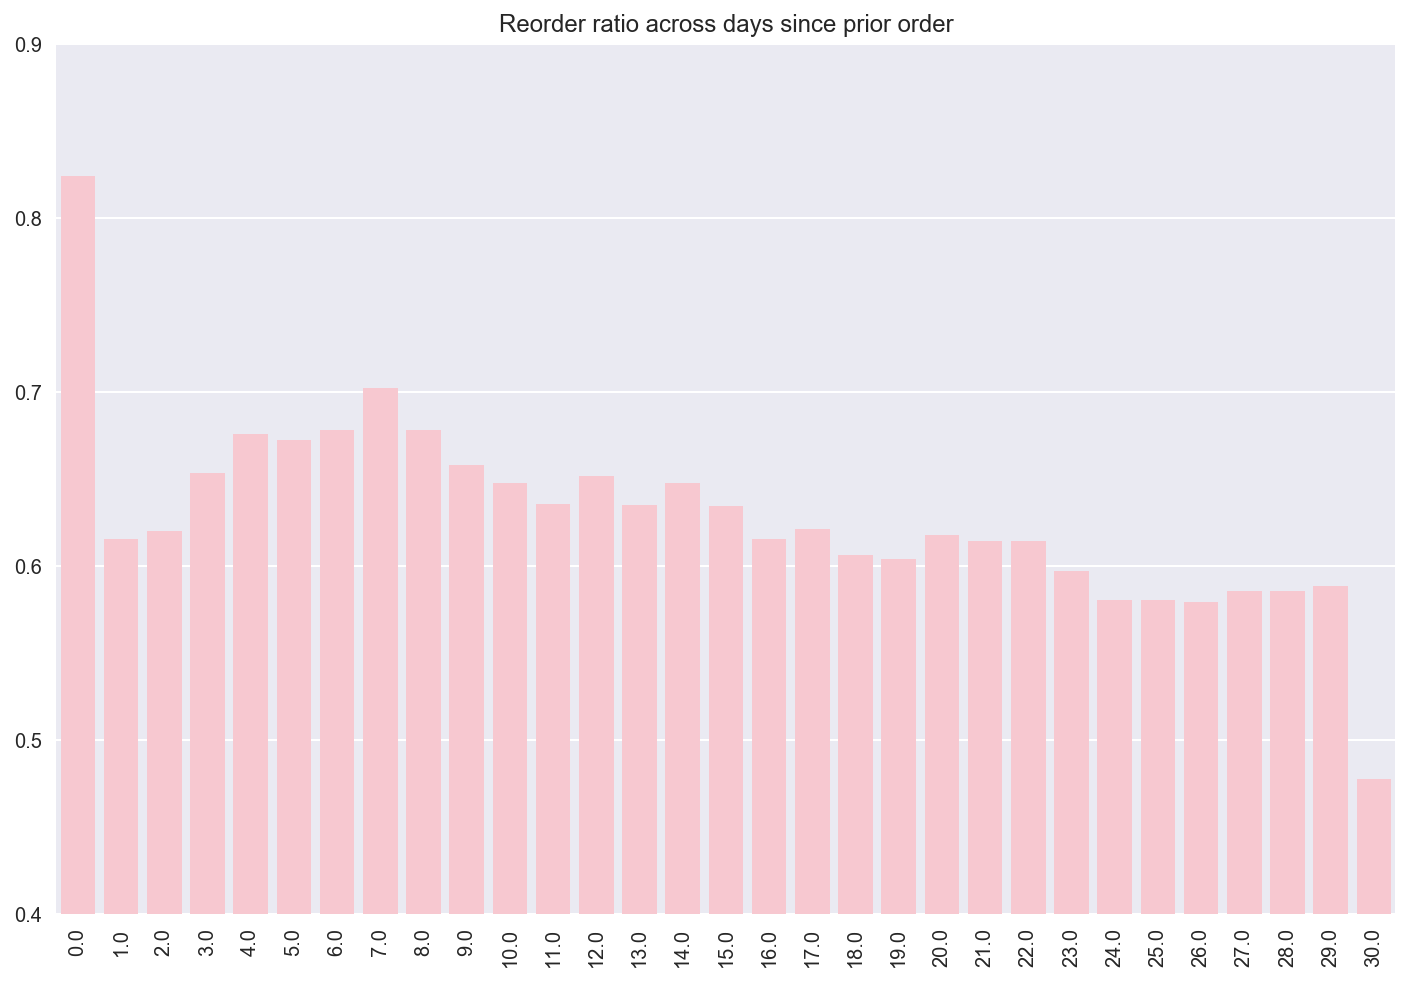

In [14]:
trainXorders_days_since = trainXorders.groupby(["days_since_prior_order"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(trainXorders_days_since['days_since_prior_order'].values, trainXorders_days_since['reordered'].values, color='pink')
plt.title("Reorder ratio across days since prior order")
plt.xticks(rotation='vertical')
plt.ylim(0.4, 0.9)
plt.show()

Looks like same day and weekly orders are more likely to be reorders. We could also see mini-peaks around 14, 21 and 28 days (weekly intervals). A bulk of the weekly reorders are likely to be scheduled, while same day reorders are likely when users realize they haven't enough.

## Preprocessing

Let's stringify the `product_id` and build the sequential list of `product_id`s in each order.

In [59]:
priors = pd.read_csv(data_path + '/order_products__prior.csv')
train = pd.read_csv(data_path + '/order_products__train.csv')
# train['product_id'] = train['product_id'].astype(str)
# priors['product_id'] = priors['product_id'].astype(str)

In [60]:
train_products = train.groupby('order_id').apply(lambda order: order['product_id'].tolist())
priors_products = priors.groupby('order_id').apply(lambda order: order['product_id'].tolist())

In [61]:
train_products.head()

order_id
1     [49302, 11109, 10246, 49683, 43633, 13176, 472...
36    [39612, 19660, 49235, 43086, 46620, 34497, 486...
38    [11913, 18159, 4461, 21616, 23622, 32433, 2884...
96    [20574, 30391, 40706, 25610, 27966, 24489, 39275]
98    [8859, 19731, 43654, 13176, 4357, 37664, 34065...
dtype: object

In [62]:
priors_products.head()

order_id
2    [33120, 28985, 9327, 45918, 30035, 17794, 4014...
3    [33754, 24838, 17704, 21903, 17668, 46667, 174...
4    [46842, 26434, 39758, 27761, 10054, 21351, 225...
5    [13176, 15005, 47329, 27966, 23909, 48370, 132...
6                                [40462, 15873, 41897]
dtype: object

In [63]:
order_products = priors_products.append(train_products).values

In [64]:
order_products[:5]

array([[33120, 28985, 9327, 45918, 30035, 17794, 40141, 1819, 43668],
       [33754, 24838, 17704, 21903, 17668, 46667, 17461, 32665],
       [46842, 26434, 39758, 27761, 10054, 21351, 22598, 34862, 40285, 17616, 25146, 32645, 41276],
       [13176, 15005, 47329, 27966, 23909, 48370, 13245, 9633, 27360, 6348, 40878, 6184, 48002, 20914, 37011, 12962, 45698, 24773, 18569, 41176, 48366, 47209, 46522, 38693, 48825, 8479],
       [40462, 15873, 41897]], dtype=object)

Now lets grab the list of order_ids for each user.

In [ ]:
# train_products = train.groupby('order_id').apply(lambda order: order['product_id'].tolist())
users = orders.groupby('user_id')
users = pd.DataFrame()
trainXorders = pd.merge(train, orders, left_on='order_id', right_index=True, how='left')
users['all_products'] = priors.groupby('user_id')['product_id'].apply(set)

## Train Word2Vec model

In [50]:
model = gensim.models.Word2Vec(order_products, size=100, window=5, min_count=2, workers=4)

## Organize data for visualization

In [52]:
vocab = list(model.wv.vocab.keys())

## Data visualization helpers

In [53]:
def get_batch(vocab, model, n_batches=3):
    output = list()
    for i in range(0, n_batches):
        rand_int = np.random.randint(len(vocab), size=1)[0]
        suggestions = model.most_similar(positive=[vocab[rand_int]], topn=5)
        suggest = list()
        for i in suggestions:
            suggest.append(i[0])
        output += suggest
        output.append(vocab[rand_int])
    return output

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    """From Tensorflow's tutorial."""
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
#     plt.savefig(filename)
    plt.show()

## Visualize a random sample

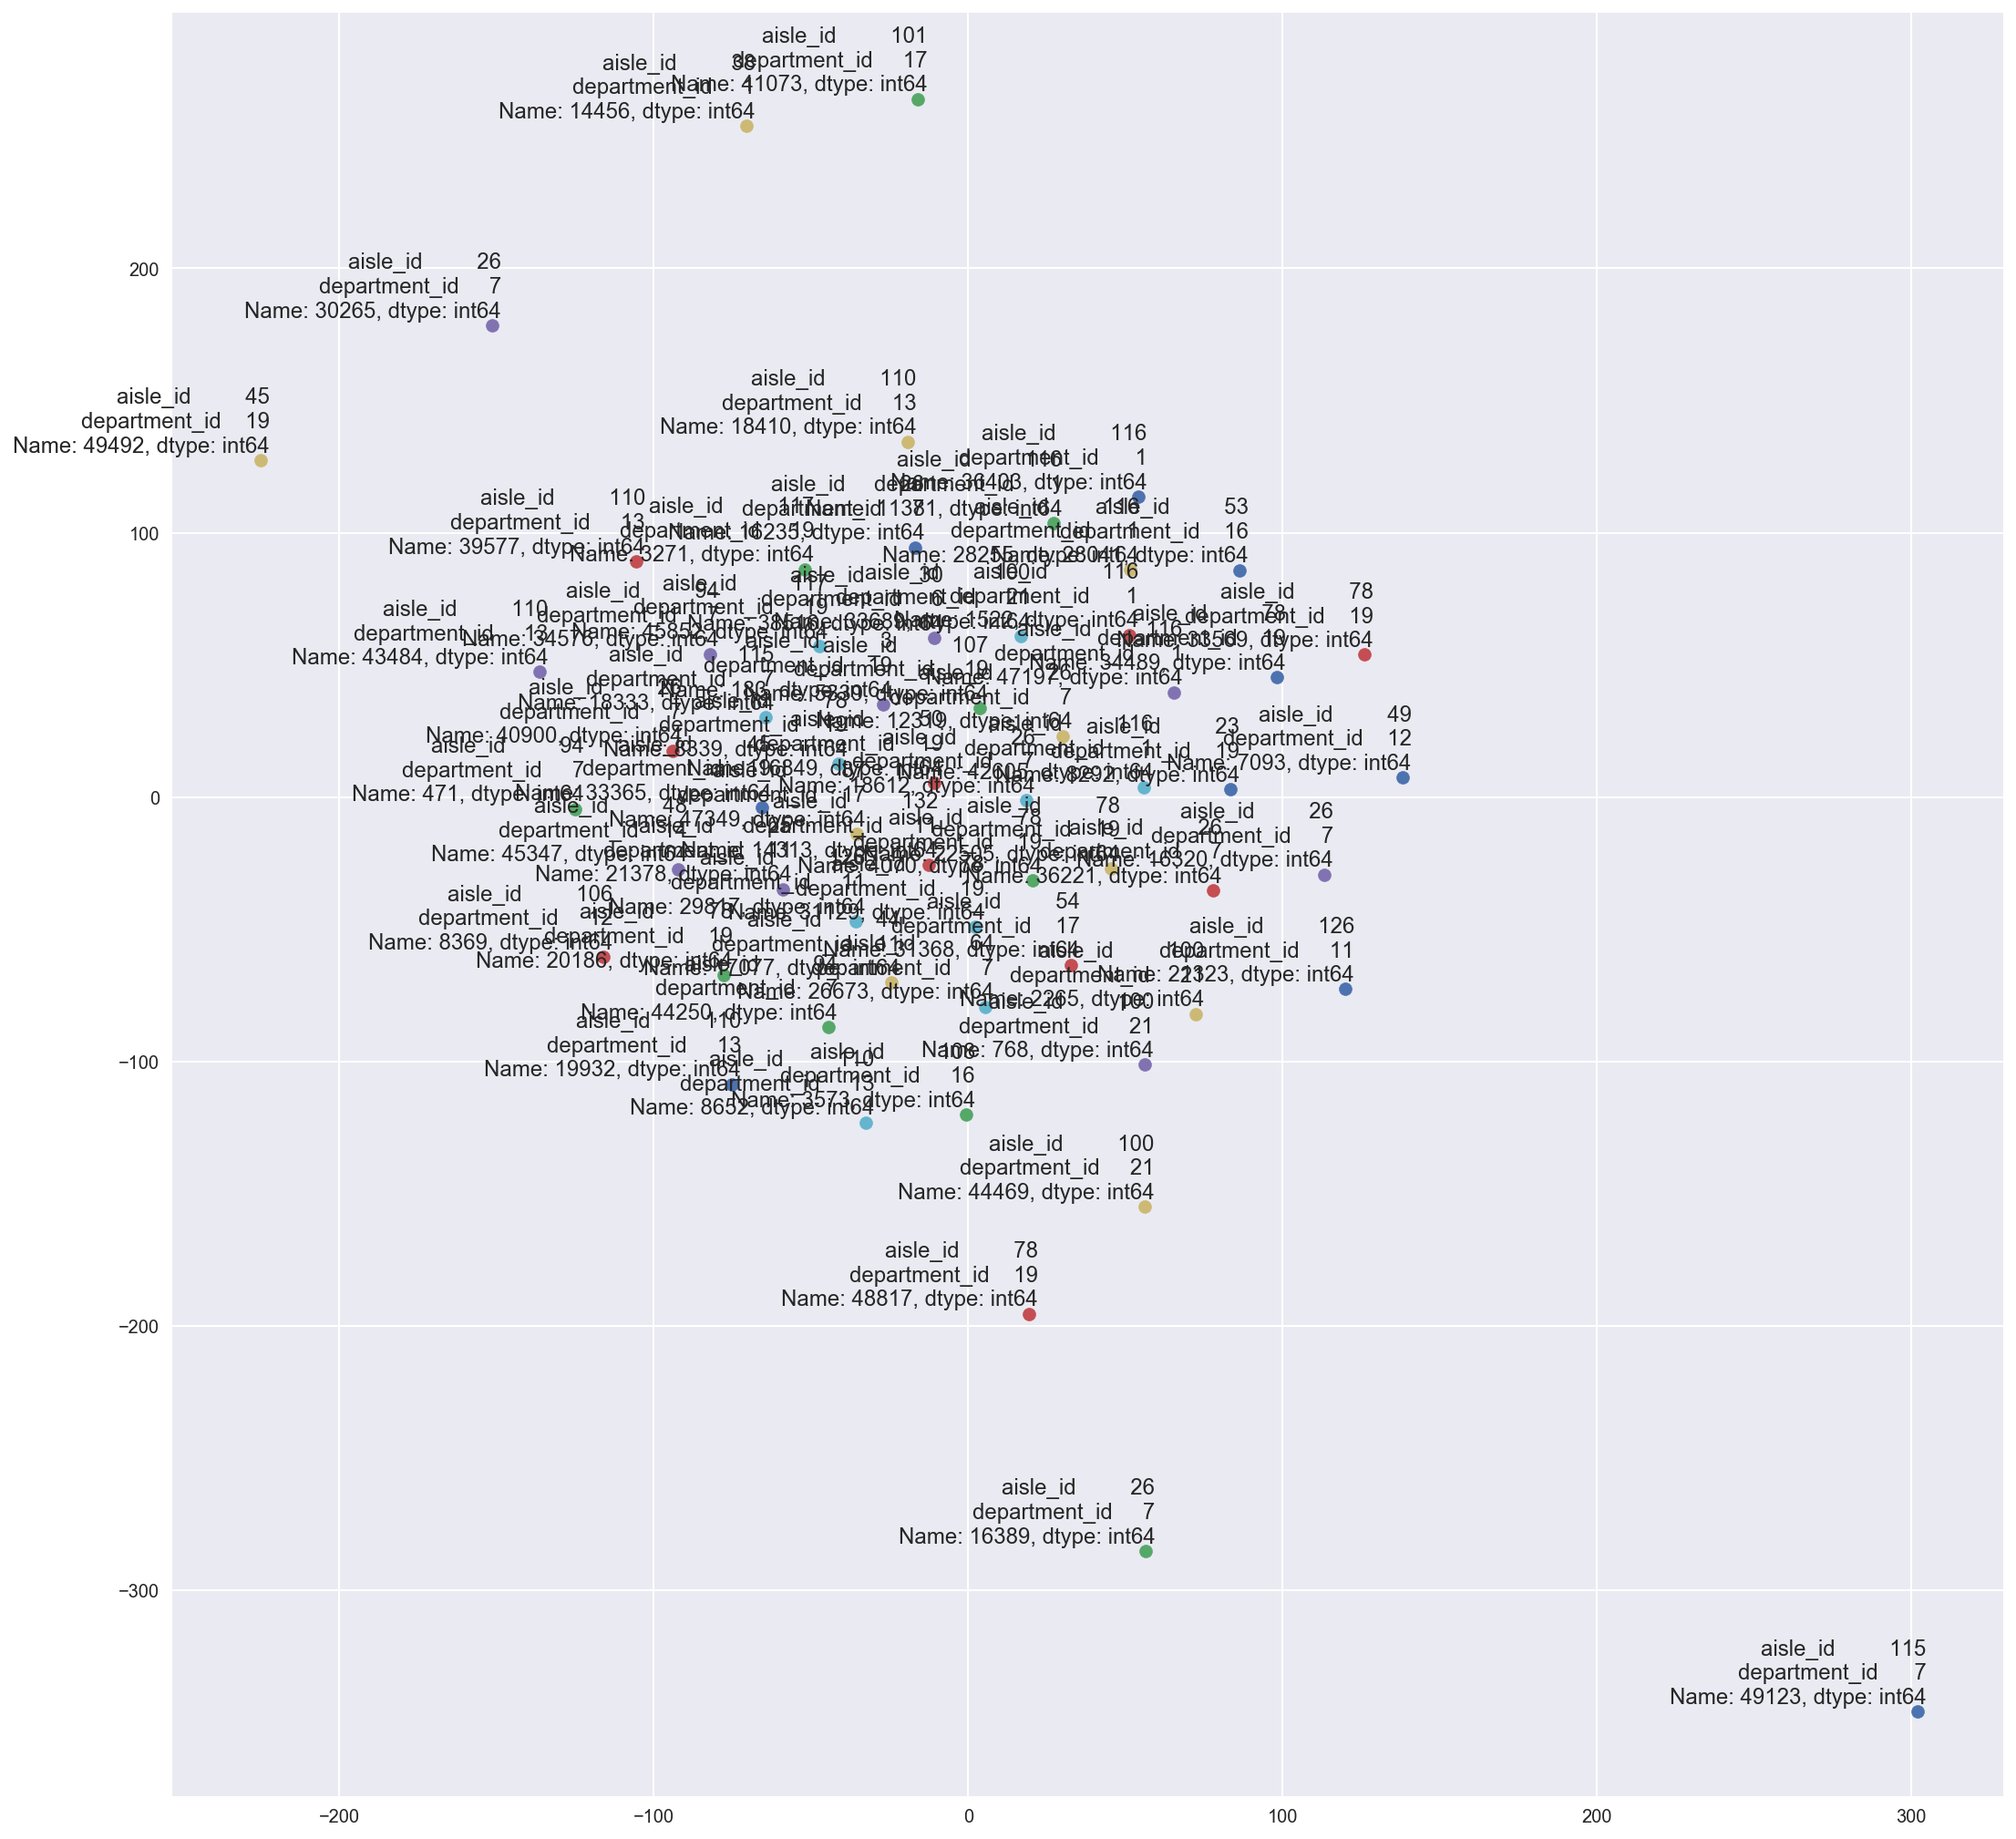

In [58]:
from sklearn.manifold import TSNE

tsne = TSNE()
embeds = []
labels = []
for item in get_batch(vocab, model, n_batches=10):
    embeds.append(model[item])
    labels.append(products.loc[int(item)]['product_name'])
embeds = np.array(embeds)

embeds = tsne.fit_transform(embeds)
plot_with_labels(embeds, labels)

## Save the model

In [ ]:
model.save("product2vec.model")

## Making Batches

In [ ]:
def get_batches(orders, batch_size, window_size=5):
    ''' Create a generator of order batches as a tuple (order, products) '''
    
    n_batches = len(orders)//batch_size
    
    # only full batches
    orders = orders[:n_batches*batch_size]
    
    for idx in range(0, len(orders), batch_size):
        x, y = [], []
        batch = orders[idx:idx+batch_size]
        for order in batch:
            products = orders[order]
            y.extend(products)
            x.extend([order]*len(products))
        yield x, y

## Building the graph

In [31]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')

## Embeddings

The embedding matrix has a size of the number of products by the number of units in the hidden layer. So, if you have 10,000 products and 300 hidden units, the matrix will have size $10,000 \times 300$.

In [34]:
n_vocab = products.shape[0]
n_embedding = 200 # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

## Negative sampling

For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct label, but only a small number of incorrect labels. This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). Tensorflow has a convenient function to do this, [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss).

In [35]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

## Validation

This code is from Thushan Ganegedara's implementation. Here we're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [37]:
import random

with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [38]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

In [ ]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

## Splitting the data into training, testing, and validation sets

We'll use the test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

We'll split the training data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [55]:
## Grab the prior set
prior_orders = orders[orders.eval_set == 'prior']

## Split the training data into train & validation sets
train_orders = orders[orders.eval_set == 'train']

## Grab the test set
test_orders = orders[orders.eval_set == 'test']

# train.set_index(['order_id', 'product_id'], inplace=True, drop=False)

In [56]:
test_orders.head()

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,
2774568,3,test,13,5,15,11.0
329954,4,test,6,3,12,30.0
1528013,6,test,4,3,16,22.0
1376945,11,test,8,6,11,8.0
1356845,12,test,6,1,20,30.0


Products + feature statistics

In [10]:
prods = pd.DataFrame()
prods['orders'] = priors.groupby(priors.product_id).size().astype(np.int32)
prods['reorders'] = priors['reordered'].groupby(priors.product_id).sum().astype(np.float32)
prods['reorder_rate'] = (prods.reorders / prods.orders).astype(np.float32)
products_stats = products.join(prods, on='product_id')
products_stats.set_index('product_id', drop=False, inplace=True)
del prods

In [11]:
products_stats.head()

,product_id,product_name,aisle_id,department_id,orders,reorders,reorder_rate
product_id,,,,,,,
1,1,Chocolate Sandwich Cookies,61,19,1852.0,1136.0,0.613391
2,2,All-Seasons Salt,104,13,90.0,12.0,0.133333
3,3,Robust Golden Unsweetened Oolong Tea,94,7,277.0,203.0,0.732852
4,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,329.0,147.0,0.446809
5,5,Green Chile Anytime Sauce,5,13,15.0,9.0,0.600000


Extending Priors with order metadata

In [12]:
orders.set_index('order_id', inplace=True, drop=False)
priors_orders = priors.join(orders, on='order_id', rsuffix='_')
priors_orders.drop('order_id_', inplace=True, axis=1)

In [13]:
priors_orders.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


User features

In [14]:
usr = pd.DataFrame()
usr['average_days_between_orders'] = orders.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
usr['nb_orders'] = orders.groupby('user_id').size().astype(np.int16)

users = pd.DataFrame()
users['total_items'] = priors_orders.groupby('user_id').size().astype(np.int16)
users['all_products'] = priors_orders.groupby('user_id')['product_id'].apply(set)
users['total_distinct_items'] = (users.all_products.map(len)).astype(np.int16)

users = users.join(usr)
del usr
users['average_basket'] = (users.total_items / users.nb_orders).astype(np.float32)
print('user features {}: {}'.format(users.shape, ', '.join(users.columns)))
users.head()

user features (206209, 6): total_items, all_products, total_distinct_items, average_days_between_orders, nb_orders, average_basket


,total_items,all_products,total_distinct_items,average_days_between_orders,nb_orders,average_basket
user_id,,,,,,
1,59,"{17122, 196, 26405, 13032, 39657, 12427, 25133...",18,19.000000,11,5.363636
2,195,"{45066, 2573, 18961, 23, 32792, 22559, 13351, ...",102,16.285715,15,13.000000
3,88,"{17668, 39190, 44683, 21903, 14992, 21137, 324...",33,12.000000,13,6.769231
4,18,"{26576, 21573, 17769, 25623, 35469, 37646, 366...",17,17.000000,6,3.000000
5,37,"{11777, 40706, 48775, 20754, 28289, 6808, 1398...",23,11.500000,5,7.400000


In [ ]:
# print('compute userXproduct features - this is long...')
# priors_orders['user_product'] = priors_orders.product_id + priors_orders.user_id * np.array(100000).astype('int64')

In [15]:
userXproduct = priors_orders.copy()
userXproduct['user_product'] = userXproduct.product_id + userXproduct.user_id * 100000
userXproduct = userXproduct.sort_values('order_number')
userXproduct = userXproduct \
    .groupby('user_product', sort=False) \
    .agg({'order_id': ['size', 'last'], 'add_to_cart_order': 'sum'})
userXproduct.columns = ['nb_orders', 'last_order_id', 'sum_pos_in_cart']
userXproduct.astype(
    {'nb_orders': np.int16, 'last_order_id': np.int32, 'sum_pos_in_cart': np.int16}, 
    inplace=True)
del priors_orders

# d= dict()
# for row in priors_orders.itertuples():
#     z = row.user_product
#     if z not in d:
#         d[z] = (1,
#                 (row.order_number, row.order_id),
#                 row.add_to_cart_order)
#     else:
#         d[z] = (d[z][0] + 1,
#                 max(d[z][1], (row.order_number, row.order_id)),
#                 d[z][2] + row.add_to_cart_order)
        
# print('to dataframe (less memory)')
# userXproduct = pd.DataFrame.from_dict(d, orient='index')
# del d
# userXproduct.columns = ['nb_orders', 'last_order_id', 'sum_pos_in_cart']
# userXproduct.nb_orders = userXproduct.nb_orders.astype(np.int16)
# userXproduct.last_order_id = userXproduct.last_order_id.map(lambda x: x[1]).astype(np.int32)
# userXproduct.sum_pos_in_cart = userXproduct.sum_pos_in_cart.astype(np.int16)
# del priors_orders
# print('user X product features {}: {}'.format(userXproduct.shape, ', '.join(userXproduct.columns)))
# userXproduct.head()

build list of candidate products to reorder, with features

In [18]:
def features(selected_orders, labels_given=False):
    print('build candidate list')
    
    order_list = []
    product_list = []
    labels = []

    train_index = set(train.index)     

    for row in selected_orders.itertuples():
        user_id = row.user_id
        order_id = row.order_id

        user_prods = users['all_products'][user_id]
        product_list += user_prods
        order_list += [order_id] * len(user_prods)

        if labels_given:
            labels += [(order_id, prod) in train_index for prod in user_prods]
        
    df = pd.DataFrame({'order_id': order_list, 'product_id': product_list}, dtype=np.int32)
    labels = np.array(labels, dtype=np.int8)
    del order_list
    del product_list
    
    print('user related features')
    df['user_id'] = df.order_id.map(orders.user_id)
    df['user_total_orders'] = df.user_id.map(users.nb_orders)
    df['user_total_items'] = df.user_id.map(users.total_items)
    df['total_distinct_items'] = df.user_id.map(users.total_distinct_items)
    df['user_average_days_between_orders'] = df.user_id.map(users.average_days_between_orders)
    df['user_average_basket'] =  df.user_id.map(users.average_basket)
    
    print('order related features')
    # df['dow'] = df.order_id.map(orders.order_dow)
    df['order_hour_of_day'] = df.order_id.map(orders.order_hour_of_day)
    df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order)
    df['days_since_ratio'] = df.days_since_prior_order / df.user_average_days_between_orders
    
    print('product related features')
    df['aisle_id'] = df.product_id.map(products_stats.aisle_id)
    df['department_id'] = df.product_id.map(products_stats.department_id)
    df['product_orders'] = df.product_id.map(products_stats.orders).astype(np.int32)
    df['product_reorders'] = df.product_id.map(products_stats.reorders)
    df['product_reorder_rate'] = df.product_id.map(products_stats.reorder_rate)

    print('user_X_product related features')
    df['z'] = df.user_id * 100000 + df.product_id
    df.drop(['user_id'], axis=1, inplace=True)
    df['UP_orders'] = df.z.map(userXproduct.nb_orders)
    df['UP_orders_ratio'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_last_order_id'] = df.z.map(userXproduct.last_order_id)
    df['UP_average_pos_in_cart'] = (df.z.map(userXproduct.sum_pos_in_cart) / df.UP_orders).astype(np.float32)
    df['UP_reorder_rate'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_orders_since_last'] = df.user_total_orders - df.UP_last_order_id.map(orders.order_number)
    df['UP_delta_hour_vs_last'] = abs(df.order_hour_of_day - df.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x)).astype(np.int8)
    #df['UP_same_dow_as_last_order'] = df.UP_last_order_id.map(orders.order_dow) == \
    #                                              df.order_id.map(orders.order_dow)

    df.drop(['UP_last_order_id', 'z'], axis=1, inplace=True)
    print(df.dtypes)
    print(df.memory_usage())
    return (df, labels)

In [19]:
df_train, labels = features(train_orders, labels_given=True)

build candidate list
user related features
order related features
product related features
user_X_product related features
order_id                              int32
product_id                            int32
user_total_orders                     int16
user_total_items                      int16
total_distinct_items                  int16
user_average_days_between_orders    float32
user_average_basket                 float32
order_hour_of_day                     int64
days_since_prior_order              float64
days_since_ratio                    float64
aisle_id                              int64
department_id                         int64
product_orders                        int32
product_reorders                    float32
product_reorder_rate                float32
UP_orders                             int64
UP_orders_ratio                     float32
UP_average_pos_in_cart              float32
UP_reorder_rate                     float32
UP_orders_since_last                  int

In [20]:
f_to_use = ['user_total_orders', 'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio',
       'aisle_id', 'department_id', 'product_orders', 'product_reorders',
       'product_reorder_rate', 'UP_orders', 'UP_orders_ratio',
       'UP_average_pos_in_cart', 'UP_reorder_rate', 'UP_orders_since_last',
       'UP_delta_hour_vs_last'] # 'dow', 'UP_same_dow_as_last_order'


print('formating for lgb')
d_train = lgb.Dataset(df_train[f_to_use],
                      label=labels,
                      categorical_feature=['aisle_id', 'department_id'])  # , 'order_hour_of_day', 'dow'
del df_train

formating for lgb


In [21]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 96,
    'max_depth': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5
}
ROUNDS = 100

print('light GBM train :-)')
bst = lgb.train(params, d_train, ROUNDS)
# lgb.plot_importance(bst, figsize=(9,20))
del d_train

light GBM train :-)


build candidates list for test

In [22]:
df_test, _ = features(test_orders)

print('light GBM predict')
preds = bst.predict(df_test[f_to_use])

df_test['pred'] = preds

TRESHOLD = 0.22  # guess, should be tuned with crossval on a subset of train data

build candidate list
user related features
order related features
product related features
user_X_product related features
order_id                              int32
product_id                            int32
user_total_orders                     int16
user_total_items                      int16
total_distinct_items                  int16
user_average_days_between_orders    float32
user_average_basket                 float32
order_hour_of_day                     int64
days_since_prior_order              float64
days_since_ratio                    float64
aisle_id                              int64
department_id                         int64
product_orders                        int32
product_reorders                    float32
product_reorder_rate                float32
UP_orders                             int64
UP_orders_ratio                     float32
UP_average_pos_in_cart              float32
UP_reorder_rate                     float32
UP_orders_since_last                  int

In [23]:
d = dict()
for row in df_test.itertuples():
    if row.pred > TRESHOLD:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in test_orders.order_id:
    if order not in d:
        d[order] = 'None'

sub = pd.DataFrame.from_dict(d, orient='index')

sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv('sub.csv', index=False)